In [1]:
import keras
keras.__version__

/home/pzhang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
original_dataset_dir = '/home/pzhang/Downloads/ml_datasets/cat-and-dog'

base_dir = '/home/pzhang/Downloads/ml_datasets/cat-and-dog-small'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [4]:
!ls /home/pzhang/Downloads/ml_datasets/cat-and-dog/test_set

cats  dogs


In [5]:
!ls /home/pzhang/Downloads/ml_datasets/cat-and-dog/test_set/cats | wc -l
!ls /home/pzhang/Downloads/ml_datasets/cat-and-dog/test_set/dogs | wc -l

1012
1013


测试集中约有2000个样本

In [6]:
!ls /home/pzhang/Downloads/ml_datasets/cat-and-dog/training_set/cats | wc -l
!ls /home/pzhang/Downloads/ml_datasets/cat-and-dog/training_set/dogs | wc -l

4001
4006


 训练集大概有 8000 个样本

## 划分验证集

In [7]:
train_path = os.path.join(original_dataset_dir, 'training_set')
test_path = os.path.join(original_dataset_dir, 'test_set')

train_path_cats = os.path.join(train_path, 'cats')
train_path_dogs = os.path.join(train_path, 'dogs')

path_cats = [
    os.path.join(train_path_cats, path) for path in os.listdir(train_path_cats)
    if '.jpg' in path
]
path_dogs = [
    os.path.join(train_path_dogs, path) for path in os.listdir(train_path_dogs)
    if '.jpg' in path
]

len(path_cats), len(path_dogs)

(4000, 4005)

将训练集8000个样本中的6000做训练集，余下的2000个样本当做验证集。需要注意的是，训练和验证集中`cat`和`dog`的比例均为50%。

In [8]:
from keras.preprocessing import image

train_set = np.zeros((6000, 150, 150, 3), dtype=np.float32)
for i in range(6000):
    img = image.load_img(
        path_cats[i] if i < 3000 else path_dogs[i - 3000],
        target_size=(150, 150))

    train_set[i] = image.img_to_array(img)

In [9]:
train_set.shape

(6000, 150, 150, 3)

In [10]:
# load validation set
val_set = np.zeros((2000, 150, 150, 3), dtype=np.float32)

for i in range(2000):
    img = image.load_img(
        path_cats[i + 3000] if i < 1000 else path_dogs[i + 2000],
        target_size=(150, 150))

    val_set[i] = image.img_to_array(img)

In [11]:
val_set.shape

(2000, 150, 150, 3)

## 创建目标张量

labels

In [12]:
# 1: dog; 0: cat
train_labels = np.zeros((3000, ))
train_labels = np.r_[train_labels, np.ones((3000,))]

val_labels = np.zeros((1000,))
val_labels = np.r_[val_labels, np.ones((1000,))]

## 数据预处理

大概分为以下几个步骤

1. 读取图像文件
 

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# data generator
datagen = ImageDataGenerator(rescale=1. / 255)

batch_size = 32

train_generator = datagen.flow(train_set, train_labels, batch_size=batch_size)

val_generator = datagen.flow(val_set, val_labels, batch_size=batch_size)

## 创建模型


In [14]:
from keras import models, layers, optimizers, losses, metrics

model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [16]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

In [17]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_set.shape[0] // batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_set.shape[0] // batch_size)

Epoch 1/30
187/187 [==============================] - 16s 88ms/step - loss: 0.6741 - binary_accuracy: 0.5680 - val_loss: 0.6423 - val_binary_accuracy: 0.6487
Epoch 2/30
187/187 [==============================] - 12s 65ms/step - loss: 0.6207 - binary_accuracy: 0.6613 - val_loss: 0.6147 - val_binary_accuracy: 0.6509
Epoch 3/30
187/187 [==============================] - 12s 66ms/step - loss: 0.5633 - binary_accuracy: 0.7037 - val_loss: 0.6687 - val_binary_accuracy: 0.6067
Epoch 4/30
187/187 [==============================] - 12s 66ms/step - loss: 0.5269 - binary_accuracy: 0.7365 - val_loss: 0.5366 - val_binary_accuracy: 0.7383
Epoch 5/30
187/187 [==============================] - 12s 65ms/step - loss: 0.4904 - binary_accuracy: 0.7600 - val_loss: 0.5096 - val_binary_accuracy: 0.7495
Epoch 6/30
187/187 [==============================] - 12s 65ms/step - loss: 0.4599 - binary_accuracy: 0.7802 - val_loss: 0.5012 - val_binary_accuracy: 0.7591
Epoch 7/30
187/187 [==============================] 

In [18]:
model.save('cat_and_dog_1.h5')

In [19]:
def plot_accuracy_and_loss(history):
    acc = history.history['binary_accuracy']
    loss = history.history['loss']

    val_acc = history.history['val_binary_accuracy']
    val_loss = history.history['val_loss']

    epochs = np.arange(len(acc)) + 1

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(epochs, acc, 'bo', label='Training acc')
    ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[0].legend(loc='best')

    ax[1].plot(epochs, loss, 'bo', label='Training loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[1].legend(loc='best')

    plt.show()

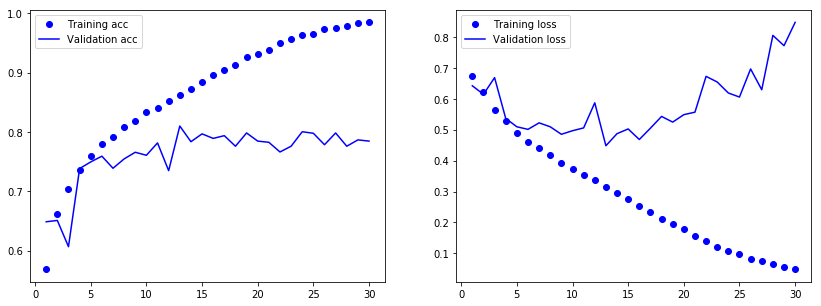

In [20]:
plot_accuracy_and_loss(history)

可以看到，大约5次迭代后就过拟合了！验证精度停留在75%左右。

## 数据增强

因训练数据太少导致的过拟合，可以使用数据增强（data argument）来降低。

In [21]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

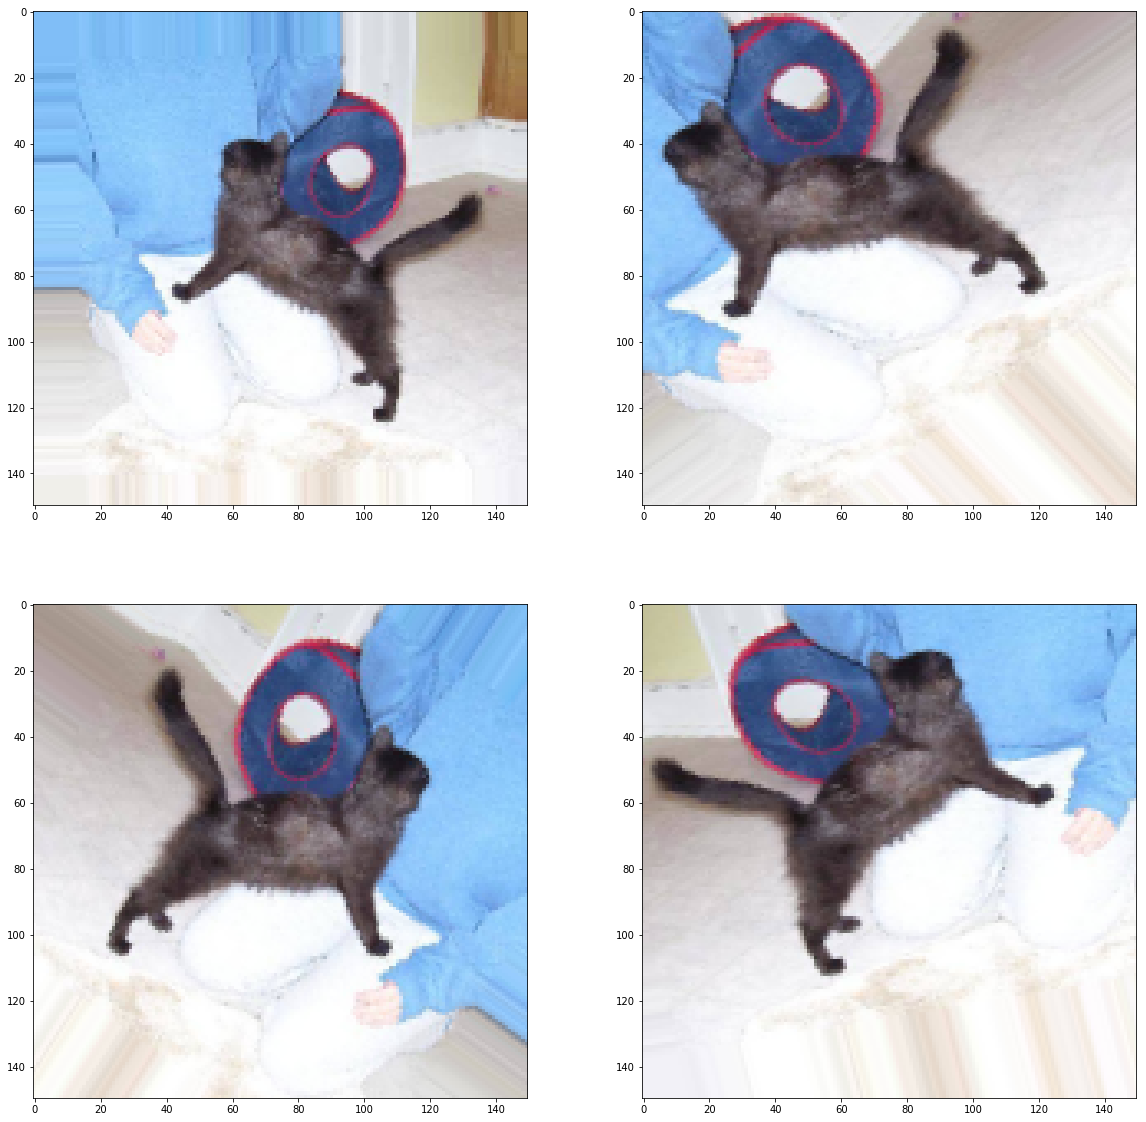

In [22]:
# 随便选一张图像来看看效果

x = train_set[8]
x = np.expand_dims(x, axis=0) / 255.

plt.figure(figsize=(20, 20))
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2, 2, i + 1)
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [23]:
# 定义一个包含dropout的新CNN

model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy])

In [24]:
# 使用数据增强来训练

datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow(train_set, train_labels, batch_size=batch_size)

val_generator = test_datagen.flow(val_set, val_labels, batch_size=batch_size)

In [25]:
# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_set.shape[0] // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_set.shape[0] // batch_size)

Epoch 1/100
187/187 [==============================] - 19s 102ms/step - loss: 0.6921 - binary_accuracy: 0.5216 - val_loss: 0.6783 - val_binary_accuracy: 0.5514
Epoch 2/100
187/187 [==============================] - 19s 102ms/step - loss: 0.6703 - binary_accuracy: 0.5810 - val_loss: 0.6580 - val_binary_accuracy: 0.5981
Epoch 3/100
187/187 [==============================] - 19s 101ms/step - loss: 0.6475 - binary_accuracy: 0.6151 - val_loss: 0.6394 - val_binary_accuracy: 0.6275
Epoch 4/100
187/187 [==============================] - 19s 101ms/step - loss: 0.6267 - binary_accuracy: 0.6449 - val_loss: 0.6106 - val_binary_accuracy: 0.6717
Epoch 5/100
187/187 [==============================] - 19s 100ms/step - loss: 0.6088 - binary_accuracy: 0.6691 - val_loss: 0.5903 - val_binary_accuracy: 0.6865
Epoch 6/100
187/187 [==============================] - 19s 101ms/step - loss: 0.5920 - binary_accuracy: 0.6823 - val_loss: 0.5855 - val_binary_accuracy: 0.6799
Epoch 7/100
187/187 [===================

187/187 [==============================] - 18s 96ms/step - loss: 0.3787 - binary_accuracy: 0.8277 - val_loss: 0.5550 - val_binary_accuracy: 0.7612
Epoch 53/100
187/187 [==============================] - 18s 95ms/step - loss: 0.3762 - binary_accuracy: 0.8287 - val_loss: 0.3958 - val_binary_accuracy: 0.8323
Epoch 54/100
187/187 [==============================] - 18s 95ms/step - loss: 0.3803 - binary_accuracy: 0.8254 - val_loss: 0.3599 - val_binary_accuracy: 0.8445
Epoch 55/100
187/187 [==============================] - 18s 96ms/step - loss: 0.3817 - binary_accuracy: 0.8274 - val_loss: 0.4082 - val_binary_accuracy: 0.8343
Epoch 56/100
187/187 [==============================] - 18s 95ms/step - loss: 0.3672 - binary_accuracy: 0.8392 - val_loss: 0.3940 - val_binary_accuracy: 0.8389
Epoch 57/100
187/187 [==============================] - 18s 96ms/step - loss: 0.3639 - binary_accuracy: 0.8387 - val_loss: 0.3337 - val_binary_accuracy: 0.8592
Epoch 58/100
187/187 [==============================]

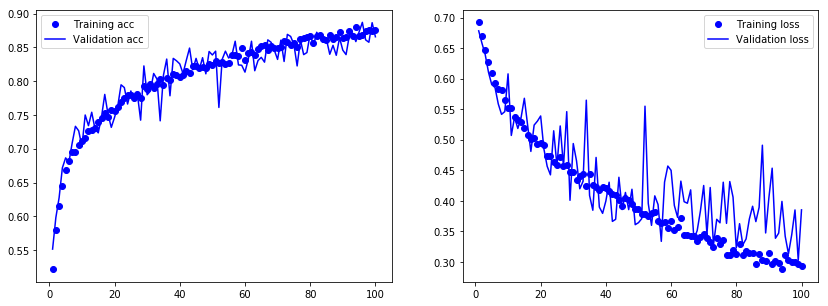

In [26]:
plot_accuracy_and_loss(history)

可以看到使用数据增强和Dropout后，验证精度提高到了85%左右，整整提高了10个百分点！！

In [27]:
model.save('cat_and_dog_2.h5')

## VGG16预训练

接下来我们使用在ImageNet上训练好的VGG16模型作为预训练模型来提高精度试试。

### 特征提取

In [28]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 234s 4us/step


In [29]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________